# Age estimation of galaxies 

## The continuum shape (21-03-23)

With respect to the analysis we carried out on the $14^{th}$ of March 2023, we would now want to use the Python language to build up a program that helps us verify the hypothesis on the age difference between the three galaxies more consistently. The structure of the program is as it follows: 

1) Build a mass array, where we choose a maximum and minimum value of the mass; 

2) Build a wavelength array: this will help to produce the bb-spectra for the galaxies, given the stars' emission;

3) Define a function that evaluates the total spectra of each galaxy in the hypothesis that stars are the only ones to contribute to it. This will need some parameters, because at different times we the brightest stars have all burned out; 

To proceed we listed the assumtions we made: 

- All stars come from the main sequence; 
- They reasonably can be considered as bbs in their emission; 
- $M_{min} = 0.1 M_{\odot}$;
- $M_{max} = 200 M_{\odot}$;
- We have a $\textbf{simple stellar population model}$, e.g. one single population model; 
- No new stars are being produced in the meantime ($\textbf{single burst population}$).

### Code body

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.modeling.models import BlackBody
from astropy import units as u
from astropy import constants as const
from astropy.visualization import quantity_support

In [17]:
def dist_Ms(min_M, max_M, N):
    
    dM = (max_M - min_M) / N
    
    M = np.array([(min_M + i * dM) for i in range(0, N)])  # produce the mass array accordingly to the min, max choice 
    
    return M

We now produce a masses array with the chosen parameters: 

In [18]:
Ms_array = dist_Ms(0.1, 200, 10000) 

In [19]:
def lambdas(min_lambda, max_lambda, N): 
    
    dl = (max_lambda - min_lambda) / N
    
    lambdas = np.array([(min_lambda + i * dl) for i in range(0, N)])  # produce the lambda array accordingly to the min, max choice 
    
    return lambdas

In [20]:
lambda_s = lambdas(1200, 7500, 10000) # angstrom

Evaluating the constants to use for the proportionality of parameters to the stellar mass. We will set the mass units as multiples of $M_{\odot}$s. 

In [21]:
T_const = 5778 # temperature conversion constant [K / solar_masses]

In [22]:
t_const = 10e9 # # time conversion constant [yrs / solar_masses]

Defining some functions to easily evaluate the age of a star and the temperature:

In [23]:
def star_age(mass): 
    
    return t_const * mass**(-2.5)


def star_temp(mass): 
    
    return T_const * mass**(0.5)

Create a Stellar Population Model function to extract the total flux of a galaxy, based on its age and initial stellar population:

In [24]:
def SP_Model(masses_array, age_galaxy, lambda_array):
    
    b0 = BlackBody(temperature=1000 * u.K, scale=0. * u.erg / (u.cm **2 * u.AA * u.s * u.sr))
    totf = b0(lambda_array)
    
    for mass in masses_array:
        
        if star_age(mass) >= age_galaxy: 
            
            bb = BlackBody(temperature=star_temp(mass) * u.K, scale=1. * u.erg / (u.cm **2 * u.AA * u.s * u.sr))
            wav = lambda_array* u.AA
            
            bol_flux = bb(wav) / bb.bolometric_flux.value * mass**1.15
            totf += bol_flux
    
    
    return totf

## Primary results

In [25]:
flux = {}  # dictionary to store the results at different ages

In [26]:
import numpy as np

In [27]:
gal_ages = np.array([14e9, 7e9, 3e9, 1e9, 1e8])
colors = ["red", "orange",  "yellow", "green", "blue"]

for i in range(0, len(gal_ages)): 

    flux[f"index = {i}"] = SP_Model(Ms_array, gal_ages[int(i)], lambda_s)

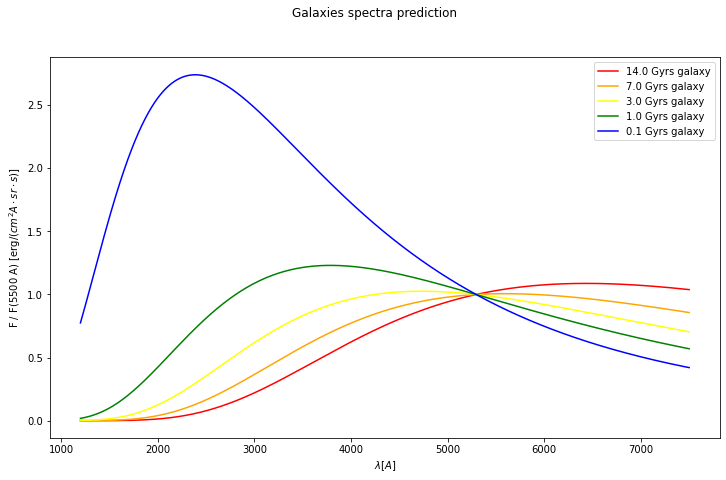

In [28]:
#lambda_H = 6562  # A

plt.figure(figsize=(12, 7))

i_color = 0

for i in range(0, len(gal_ages)):
    
    plt.plot(lambda_s, flux[f"index = {i}"] / flux[f"index = {i}"][6500], c = colors[i_color], label=f"{gal_ages[i] / 1e9} Gyrs galaxy")  
    i_color += 1
    
plt.xlabel("$\lambda [A]$")
plt.ylabel("F / F(5500 A) [$\mathrm{erg} / (cm^2 A \cdot sr \cdot s)$]")
plt.suptitle("Galaxies spectra prediction")
plt.legend();

With respect to the $G1$, $G2$, and $G3$ galaxies present in the slides we have the maximum wavelengths at about: 

- G1) $\lambda \sim 4000 \mathrm{A}$
- G2) $\lambda \sim 4700 \mathrm{A}$
- G3) $\lambda \geq 6000 \mathrm{A}$

I will plot the max of the above spectra to see if their $\lambda$ values are compatible: 

In [42]:
for i in range(0, len(gal_ages)):
    
    print("l estimate: ", str(lambda_s[flux[f"index = {i}"] == np.max(flux[f"index = {i}"])]), " A")

l estimate:  [6432.6]  A
l estimate:  [5970.6]  A
l estimate:  [5410.2]  A
l estimate:  [4341.6]  A
l estimate:  [2388.6]  A


We obtain: 

- G1 $\in$ [1, 2] Gyrs
- G2 $\in$ [2, 5] Gyrs
- G3 $\geq$ 10 Gyrs

A very rough estimate, that still is okay with the assumptions we made. 

## Getting deeper into the problem (28-03-23)

The problem we tackled with the previous lab sesson was very simple, and it was based on very strong assumptions. Today we would like to relax some of them to see how drastically our results can change. The first one is about the $\textbf{observed}$ flux, which is not necessarily the $\textbf{emitted}$ on of the galaxy. What does it mean? It means that we should consider there might some attenuation processes that we previously ignored. We don't know "a priori" HOW or IF they'll change the results, but we cannot ignore the presence of interstellar material in galaxies, whose presence is confirmed by the observations in our own Galaxy. 

Several people studied the properties of $\textbf{dust attenuation}$ and produced some dependency of the observed flux from this effect. The one attenuation we're going to use is: 

$$f_{obs}(\lambda) = f_{int}(\lambda) 10^{-0.4A_{\lambda}}$$

where $A_{\lambda} = k(\lambda) E(B - V)$; $A_{\lambda}$ is the magnitude, $k(\lambda)$ is the attenuation coefficient depending on the wavelength of the absorbed line, and $E(B - V)$ is the $\textit{color eccess}$. 



The function $k(\lambda)$ has been formulated differently for different galaxies types. We adopted the "Calzetti" formulation, that gives: 


$$k(\lambda) = \begin{cases} 
      2.659(-2.156 + \frac{1.509}{\lambda} - \frac{0.198}{\lambda^2} + \frac{0.011}{\lambda^3}) + R_{v} & x \in [0.12 \ \mu m, 0.63 \ \mu m] \\
      2.659(-1.857 + \frac{1.040}{\lambda}) + R_{v} & x \in [0.63 \ \mu m, 2.2 \ \mu m] 
   \end{cases}
$$

with $R_{v} = 4.05$

In [58]:
def k(lambdas): 
    
    ks = []
    
    for l in lambdas: 
        
        if l <= 6300 and l >= 1200:
            
            ks.append(2.659 * (-2.156 + 1.509 * 1e4/l - 0.198 * 1e8/l**2 + 0.011 * 1e12/l**3) + 4.05)  # 1e4 is to keep const in A and not in mu-m
            
        if l > 6300 and l <= 22000: 
            
            ks.append(2.659 * (-1.857 + 1.040 * 1e4/l) + 4.05)  # same 1e4 for A instead of mu-m
            
    return np.array(ks)

Check with the function we were given as an example (Calzetti option): 


![](image_k.png)

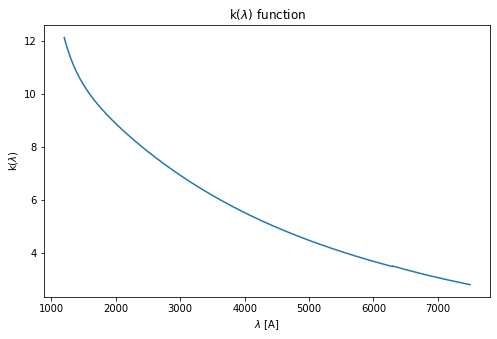

In [94]:
plt.figure(figsize=(8, 5))
plt.plot(lambda_s, k(lambda_s))
plt.xlabel("$\lambda$ [A]")
plt.ylabel("k($\lambda$)")
plt.title("k($\lambda$) function");

Okay, they match. Now we'd like to see how we expect one spectrum to change with this new factor $k$. Let's choose for instance a "young" galaxy.

In [95]:
e_colors = 0.5

absorption = 10**(- 0.4 * k(lambda_s) * e_colors)

new_obs_flux = flux[f"index = 3"] * absorption

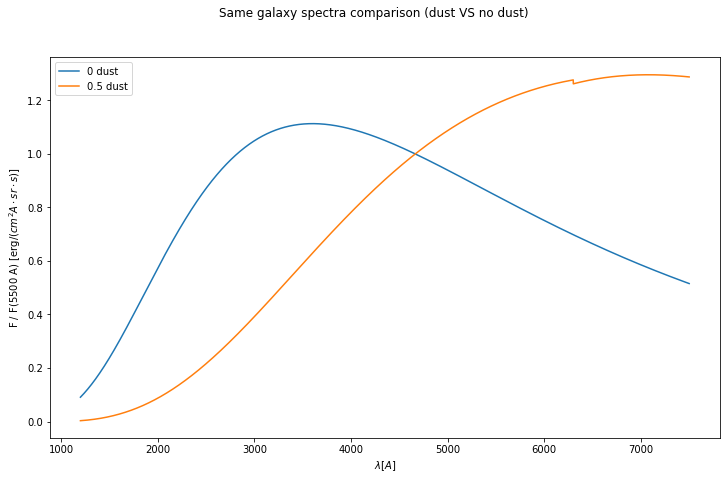

In [96]:
#lambda_H = 6562  # A

plt.figure(figsize=(12, 7))

plt.plot(lambda_s, flux[f"index = 3"] / flux[f"index = 3"][5500], label=f"0 dust")  
plt.plot(lambda_s, new_obs_flux / new_obs_flux[5500], label=f"0.5 dust") 
    
plt.xlabel("$\lambda [A]$")
plt.ylabel("F / F(5500 A) [$\mathrm{erg} / (cm^2 A \cdot sr \cdot s)$]")
plt.suptitle("Same galaxy spectra comparison (dust VS no dust)")
plt.legend();

The peak moves away from the blue and gets onto the "redder" frequencies! How can we distinguish then from a young, dusty galaxy and an old un-dusty galaxy? See your notes for the qualitative answer. The latter relies on the absorption lines and emission lines of the spectra, hich give you different information but help you distinguish these types of galaxies. 

# Extracting some useful parameters from our model (e.g. $M_{tot}$ of the galaxy) (4-04-23)

In this section we are trying to estimate the $M_{tot}$ of $S1$, $S2$, $S3$ and $S4$ galaxies' fluxes. I am gonna here report some notes (star formation parts excluded) taken during the lectures.

The previous lab-session we have neglected the constant $\xi_0$ that was present in the calculation of Salpeter's IMF: 

$$dN = \xi_0 M^{-2.35} dM$$

If we evaluate it in terms of the $M_{tot}$ of the galaxy, it's gonna be easy to integrate it in our $\textbf{SP_Model}$ calculation of the BB superposition. Basically we just have to integrate over the chosen mass range: 

$$M_{tot} = \int_{M_{min}}^{M_{max}} M dN = \int_{M_{min}}^{M_{max}} \xi_0 M^{-1.35} dM = \frac{1}{-0.35} \xi_0 (M_{max}^{-0.35} - M_{min}^{-0.35})$$ 

returning $\xi_0 = \frac{(-0.35)M_{tot}}{(M_{max}^{-0.35} - M_{min}^{-0.35})}$. 
This value will correct the BB spectrum.


We first need to fetch the data from $\texttt{.fits}$ files. 

In [204]:
from astropy.io import fits
import glob

Loading the data:

In [205]:
filenames=glob.glob('./S*.fits')

In [206]:
data = {}

for i in range(1, 5): 
    
    data[f"S{i}"] = fits.open(filenames[i - 1])

In [207]:
s1_data = data["S1"][1].data
s2_data = data["S2"][1].data
s3_data = data["S3"][1].data
s4_data = data["S4"][1].data

### S1

In [208]:
s1_flux = s1_data['flux']
s1_log_lam = s1_data['loglam']

Let's see the results: 

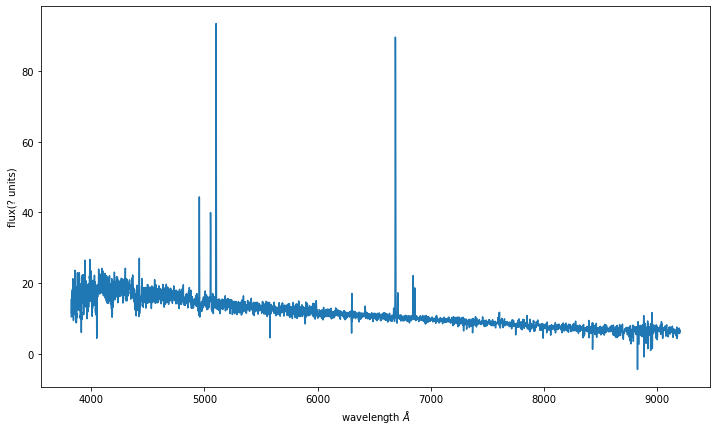

In [209]:
plt.figure(figsize=(12, 7))
plt.plot(10 ** s1_log_lam, s1_flux)
plt.xlabel(r'wavelength $\AA$')
plt.ylabel('flux(? units)')
plt.show(); 

We would like to convert the flux we have here in terms of a $\textit{specific luminosity}$, which is the output of our $\textbf{SP_Model}$ above, in order to compare the two. First we need to know how redshifted the galaxy is so that we can extrapolate the $\textit{luminosity distance}$. 

In [210]:
import numpy.ma as ma

In [211]:
s1_wav_arr = np.array(10 ** s1_log_lam)
s1_region=ma.masked_inside(s1_wav_arr,6500,7000)

In [212]:
redshifted_H_alpha = s1_wav_arr[np.where(s1_flux == np.max(s1_flux[s1_region.mask]))][0]
theor_H_alpha = 6564.6  # AA

In [213]:
s1_z = (redshifted_H_alpha - theor_H_alpha) / redshifted_H_alpha
print(s1_z)

0.018459341259610254


Using $\texttt{astropy}$ to get the luminosity distance: 

In [214]:
from astropy.cosmology import Planck18 as cosmo
from astropy import units as u

In [215]:
s1_dist=cosmo.luminosity_distance(s1_z).to(u.cm)

In [216]:
s1_lum=4 * np.pi * (s1_dist**2) * s1_flux*10**(-17) * (1 + s1_z)**2  # 10^-17 is the units of flux from datafile

Now getting the correct results: 

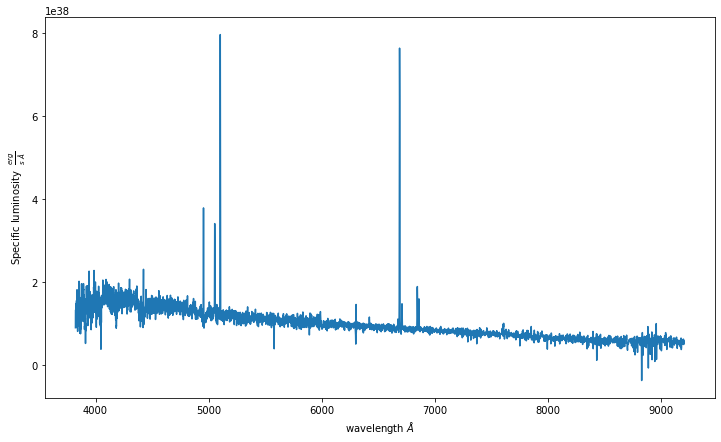

In [217]:
plt.figure(figsize=(12, 7))
plt.plot(s1_wav_arr,s1_lum)
plt.xlabel('wavelength $\AA$')
plt.ylabel(r'Specific luminosity  $\frac{erg}{s \ \AA}$')
plt.show();

In [218]:
np.savetxt('S1.txt', (s1_wav_arr, s1_lum))

Let's have a wonderful check on this! We cleverly know from the spectrum we see that the galaxy is young, so we will probe only small $t_{gal}$ parameters (also because otherwise we have a degeneration: older galaxy but smaller mass or the opposite). 

In [219]:
def SP_Model_eps(masses_array, age_galaxy, lambda_array, M_tot):
    
    alpha = 2.35
    b0 = BlackBody(temperature=1000 * u.K, scale=0. * u.erg / (u.cm **2 * u.AA * u.s * u.sr))
    totf = b0(lambda_array)
    
    # adding epsilon we discussed before:
    
    epsilon_0 = (2 - alpha) * M_tot / (np.max(masses_array)**(2-alpha) - np.min(masses_array)**(2-alpha))
    
    for mass in masses_array:
        
        if star_age(mass) >= age_galaxy: 
            
            bb = BlackBody(temperature=star_temp(mass) * u.K, scale=1. * u.erg / (u.cm **2 * u.AA * u.s * u.sr))
            wav = lambda_array* u.AA
            
            bol_flux = bb(wav) / bb.bolometric_flux.value * epsilon_0 * mass**(1.15)
            totf += bol_flux
    
    
    return totf

In [220]:
gal_age = 1e9  #Gyrs
M_tot_s1 = 1e7 # solar M

s1_model_flux = SP_Model_eps(Ms_array, gal_age, lambda_s, M_tot_s1)

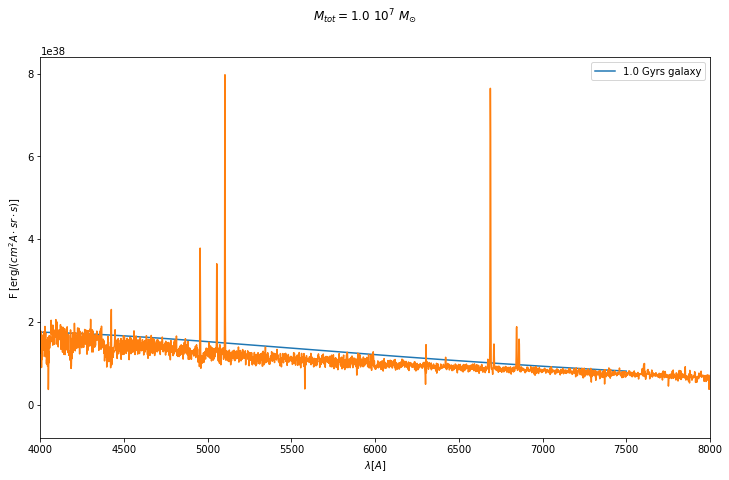

In [221]:
plt.figure(figsize=(12, 7))
plt.plot(lambda_s, s1_model_flux * 4 * 10**33, label=f"{gal_age / 1e9} Gyrs galaxy")  # solar L
    
plt.plot(s1_wav_arr, s1_lum)
plt.xlabel("$\lambda [A]$")
plt.ylabel("F [$\mathrm{erg} / (cm^2 A \cdot sr \cdot s)$]")
plt.suptitle("$M_{tot}"f" = {M_tot_s1 / 1e7}"" \ 10^{7} \ M_{\odot}$")
#plt.ylim(0, 0.6e41)
plt.xlim(4000, 8000)
plt.legend()
plt.show();

Brutal, but effective. Let's do it for the other galaxies!

### S2

In [222]:
s2_flux = s2_data['flux']
s2_log_lam = s2_data['loglam']

Let's see the results:

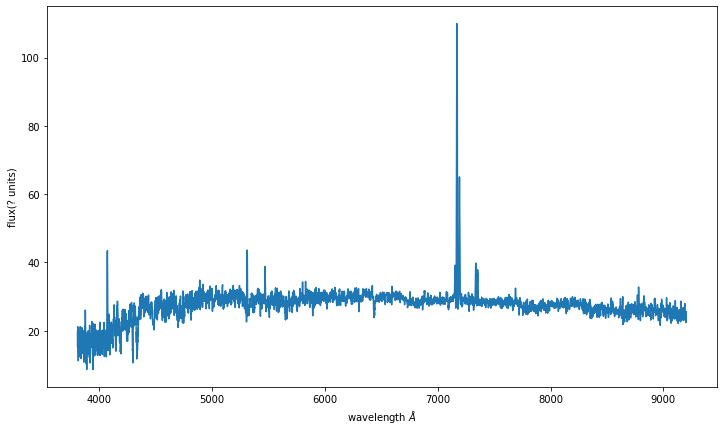

In [223]:
plt.figure(figsize=(12, 7))
plt.plot(10 ** s2_log_lam, s2_flux)
plt.xlabel(r'wavelength $\AA$')
plt.ylabel('flux(? units)')
plt.show(); 

In [224]:
s2_wav_arr = np.array(10 ** s2_log_lam)
s2_region=ma.masked_inside(s2_wav_arr,6500,7500)

In [225]:
redshifted_H_alpha_2 = s2_wav_arr[np.where(s2_flux == np.max(s2_flux[s2_region.mask]))][0]
theor_H_alpha = 6564.6  # AA

In [226]:
s2_z = (redshifted_H_alpha_2 - theor_H_alpha) / redshifted_H_alpha_2
print(s2_z)

0.08439474153050028


In [227]:
s2_dist=cosmo.luminosity_distance(s2_z).to(u.cm)

In [228]:
s2_lum=4 * np.pi * (s2_dist**2) * s2_flux*10**(-17) * (1 + s2_z)**2

Getting the correct results:

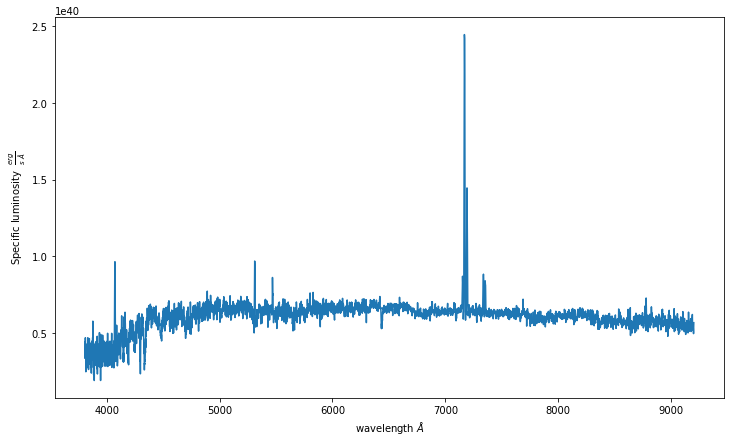

In [229]:
plt.figure(figsize=(12, 7))
plt.plot(s2_wav_arr,s2_lum)
plt.xlabel('wavelength $\AA$')
plt.ylabel(r'Specific luminosity  $\frac{erg}{s \ \AA}$')
plt.show();

In [230]:
gal_age_2 = 5.2e9  #Gyrs
M_tot_s2 = 2.3e9 # solar M

s2_model_flux = SP_Model_eps(Ms_array, gal_age_2, lambda_s, M_tot_s2)

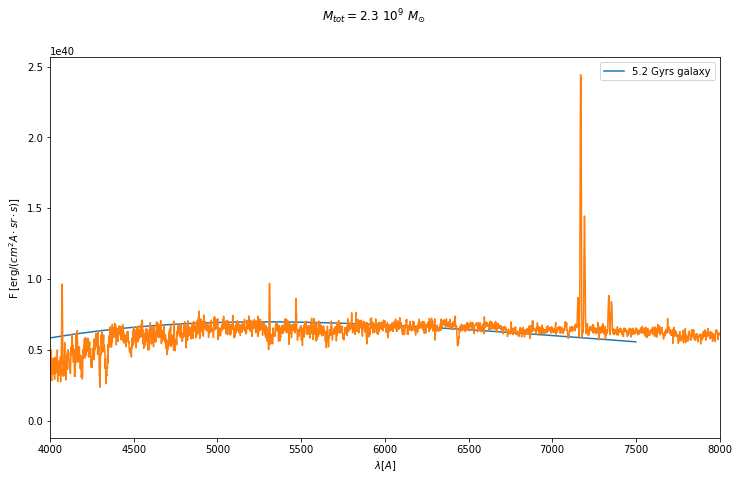

In [231]:
plt.figure(figsize=(12, 7))
plt.plot(lambda_s, s2_model_flux * 4 * 10**33, label=f"{gal_age_2 / 1e9} Gyrs galaxy")  # solar L
    
plt.plot(s2_wav_arr, s2_lum)
plt.xlabel("$\lambda [A]$")
plt.ylabel("F [$\mathrm{erg} / (cm^2 A \cdot sr \cdot s)$]")
plt.suptitle("$M_{tot}"f" = {M_tot_s2 / 1e9}"" \ 10^{9} \ M_{\odot}$")
#plt.ylim(0, 0.6e41)
plt.xlim(4000, 8000)
plt.legend()
plt.show();

Not really precise, but free to play with the code and see the best tradeoff between $M_{tot}$ and $t_{gal}$. 

### S3

In [232]:
s3_flux = s3_data['flux']
s3_log_lam = s3_data['loglam']

Let's see the results:

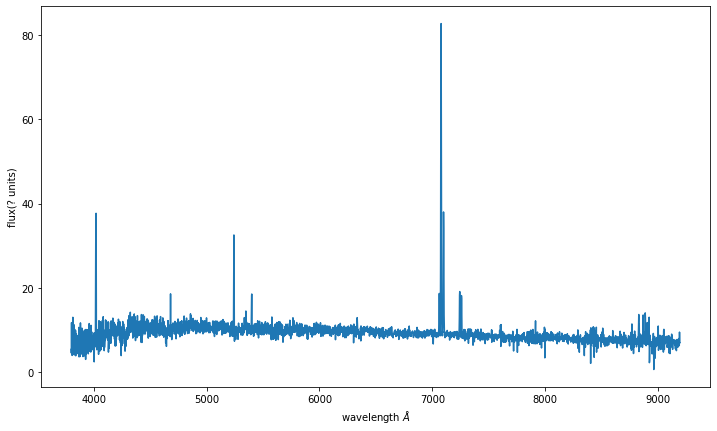

In [233]:
plt.figure(figsize=(12, 7))
plt.plot(10 ** s3_log_lam, s3_flux)
plt.xlabel(r'wavelength $\AA$')
plt.ylabel('flux(? units)')
plt.show(); 

In [234]:
s3_wav_arr = np.array(10 ** s3_log_lam)
s3_region=ma.masked_inside(s3_wav_arr,6500,7500)

In [235]:
redshifted_H_alpha_3 = s3_wav_arr[np.where(s3_flux == np.max(s3_flux[s3_region.mask]))][0]
theor_H_alpha = 6564.6  # AA

In [236]:
s3_z = (redshifted_H_alpha_3 - theor_H_alpha) / redshifted_H_alpha_3
print(s3_z)

0.07251209211865393


In [237]:
s3_dist=cosmo.luminosity_distance(s3_z).to(u.cm)

In [238]:
s3_lum=4 * np.pi * (s3_dist**2) * s3_flux*10**(-17) * (1 + s3_z)**2

Getting the correct results: 

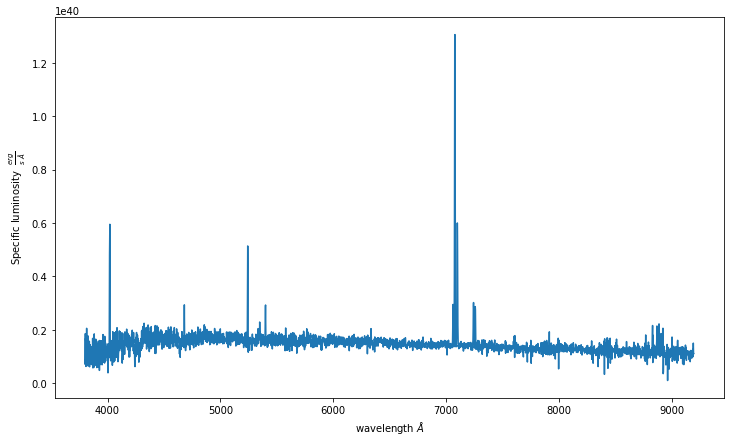

In [239]:
plt.figure(figsize=(12, 7))
plt.plot(s3_wav_arr,s3_lum)
plt.xlabel('wavelength $\AA$')
plt.ylabel(r'Specific luminosity  $\frac{erg}{s \ \AA}$')
plt.show();

In [240]:
gal_age_3 = 5e9  #Gyrs
M_tot_s3 = 0.5e9 # solar M

s3_model_flux = SP_Model_eps(Ms_array, gal_age_3, lambda_s, M_tot_s3)

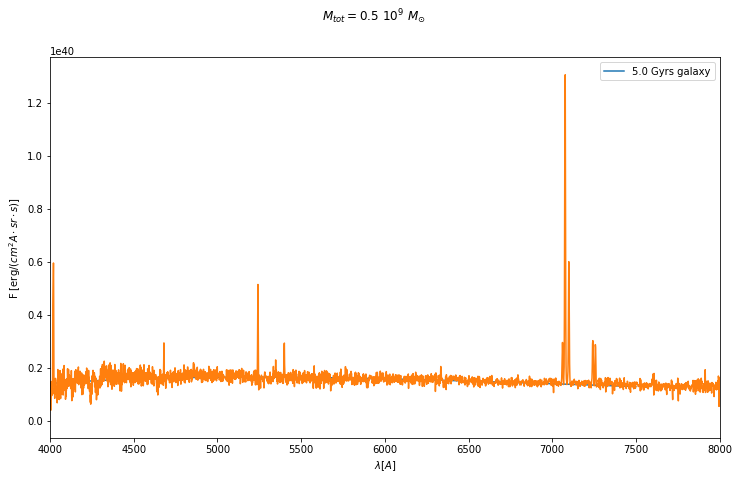

In [252]:
plt.figure(figsize=(12, 7))
plt.plot(lambda_s, s3_model_flux * 4 * 10**33, label=f"{gal_age_3 / 1e9} Gyrs galaxy")  # solar L
    
plt.plot(s3_wav_arr, s3_lum)
plt.xlabel("$\lambda [A]$")
plt.ylabel("F [$\mathrm{erg} / (cm^2 A \cdot sr \cdot s)$]")
plt.suptitle("$M_{tot}"f" = {M_tot_s3 / 1e9}"" \ 10^{9} \ M_{\odot}$")
#plt.ylim(0, 0.6e41)
plt.xlim(4000, 8000)
plt.legend()
plt.show();

Perfection!

### S4

In [243]:
s4_flux = s4_data['flux']
s4_log_lam = s4_data['loglam']

In [244]:
s4_wav_arr = np.array(10 ** s4_log_lam)

# here z was given by professor: 
z_given = 0.074

In [245]:
s4_dist=cosmo.luminosity_distance(z_given).to(u.cm)

In [246]:
s4_lum=4 * np.pi * (s4_dist**2) * s4_flux*10**(-17) * (1 + z_given)**2

Getting the correct results:

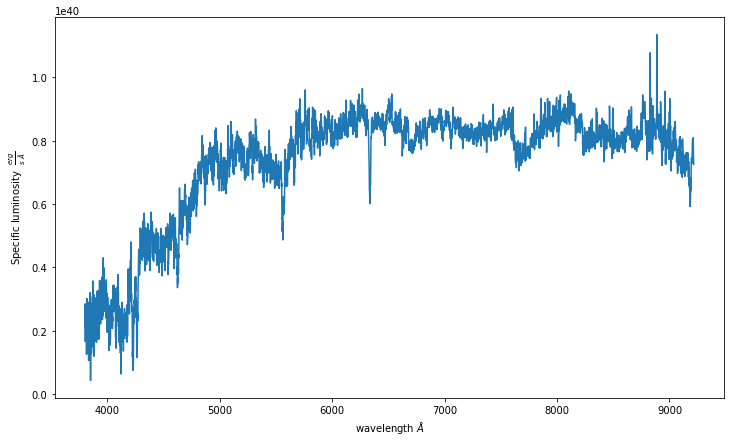

In [247]:
plt.figure(figsize=(12, 7))
plt.plot(s4_wav_arr,s4_lum)
plt.xlabel('wavelength $\AA$')
plt.ylabel(r'Specific luminosity  $\frac{erg}{s \ \AA}$')
plt.show();

In [248]:
gal_age_4 = 12e9  #Gyrs (per me è giovane ma polverosa)
M_tot_s4 = 0.7e10 # solar M

s4_model_flux = SP_Model_eps(Ms_array, gal_age_4, lambda_s, M_tot_s4)

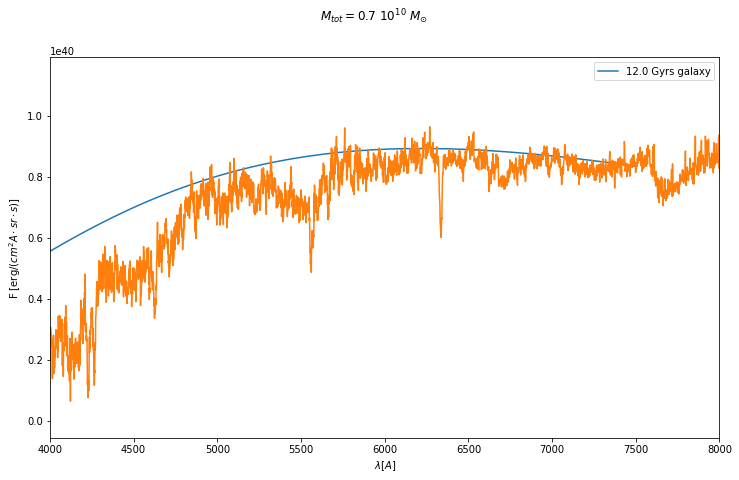

In [250]:
plt.figure(figsize=(12, 7))
plt.plot(lambda_s, s4_model_flux * 4 * 10**33, label=f"{gal_age_4 / 1e9} Gyrs galaxy")  # solar L
    
plt.plot(s4_wav_arr, s4_lum)
plt.xlabel("$\lambda [A]$")
plt.ylabel("F [$\mathrm{erg} / (cm^2 A \cdot sr \cdot s)$]")
plt.suptitle("$M_{tot}"f" = {M_tot_s4 / 1e10}"" \ 10^{10} \ M_{\odot}$")
#plt.ylim(0, 0.6e41)
plt.xlim(4000, 8000)
plt.legend()
plt.show();

Less perfect, but it's probably something wrong with the code. 